In [1]:
# Setup
import os
import numpy as np

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [84]:
def learned_parameters(model):
    return [m for m in dir(model)
            if m.endswith("_") and not m.startswith("_")]

# Clustering Algorithms

## Introduction – Classification vs Clustering

In general, *clustering* is when you try to group a set of objects and find whether there is __some__ relationship between the objects. *Classification* is when you have a set of predefined classes and want to know what class a new object belongs to.

For Machine Learning, classification is a form of *supervised learning* (e.g. learning with the labels) and clustering is a form of *unsupervised learning*. Clustering is usually used to *__explore data__*, while classification is used to predict future observations.

This graph may clear some things up:

Criteria | Classification | Clustering
--- | --- | ---
Prior knowledge of classes | Yes | No
Use Case | Classify new sample into known class | Suggest group based on pattern in data
Algorithms | Decision Trees, Bayesian classifiers, k-nearest neighbor, Logistic regression, SVC, Random Forest | k-means, Expectation maximization, DBSCAN
Data Needs | labeled samples from a set of classes | unlabeled samples


## K-Means

We'll start with K-Means clustering. The goal of the algorithm is to find *K* number of groups in the data, with _K_ being selected by the user.

In [2]:
# We'll use the blobs dataset to generate some data
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[0.2, 2.3],
     [-1.5, 2.3],
     [-2.8, 1.8],
     [-2.8, 2.8],
     [-2.8, 1.3]])

In [3]:
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

# Make data
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

In [4]:
# Plot our blobs
def plot_cluster(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$y_1$", fontsize=14)

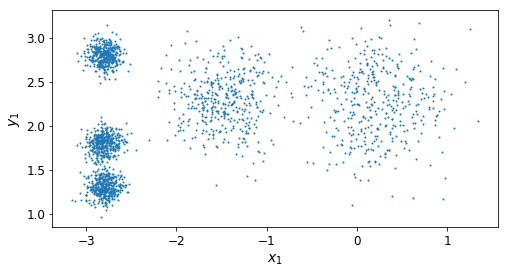

In [5]:
plt.figure(figsize=(8, 4))
plot_cluster(X)
plt.show()

### Fit and Train

We'll train a K-Means clusterer. It'll try to find the center of each blob and assign each instance to the closest blob:

In [6]:
from sklearn.cluster import KMeans

k = 5 # number of centers to find (we can see this from the plot)
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [7]:
y_pred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [8]:
y_pred is kmeans.labels_

True

The locations of the 5 centers was also predicted:

In [9]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [10]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

We're also able to predict the label of a new instance:

In [11]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

### Decision Boundaries

Now let's plot the decision boundaries. This will yield a *Voronoi diagram*:

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30, linewidths=8, color=circle_color,
                zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=50, linewidths=50, color=cross_color,
                zorder=11, alpha=1)
    
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')

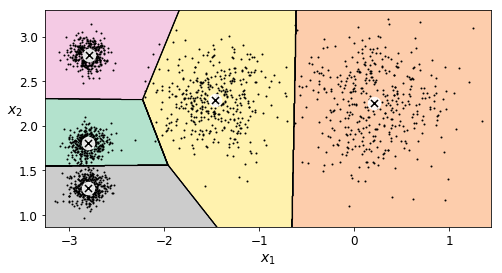

In [13]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Not bad! Some instances nere edges may have been misassigned, but overall it looks pretty good and the centers are pretty spot on.

### Hard vs Soft Clustering

Arbitrarily choosing the closest cluster per instance is known as *hard clustering*, and it's pretty good. However, it may be better to measure the distance of each instance to all 5 centroids. That is what the `transform()` method does:

In [14]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

These numbers being the $\ell_2$ norm (Eucledian distance) can be easily verified:

In [15]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

## The K-Means Algorithm

This algorithm is one of the simplest, but also one of the fastest. It works like this:

1) First initialize $k$ centroids randomly; $k$ distinct instances are chosen randomly from the dataset and centroids are placed at their locations.
2) Repeat until convergence (i.e. until the centroids stop moving)
    1) Assign each instance to the closest centroid
    2) Update the centroids to be the mean of the instances that are assigned to them
   

The `KMeans` class applies an optimized algorithm by default, but if you want the unoptimized, original algorithm (for some reason), you must use the following hyperparameters: `init='random'`, `n_init=1`, and `algorithm='full'`. These hyperparams will be explained below.

Let's run the algo for 1, 2, and 3 iterations to see how they differ and how the centroids move around:

In [16]:
kmeans_iter1 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full', max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full', max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full', max_iter=3, random_state=1)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
    n_init=1, n_jobs=1, precompute_distances='auto', random_state=1,
    tol=0.0001, verbose=0)

And let's plot this:

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


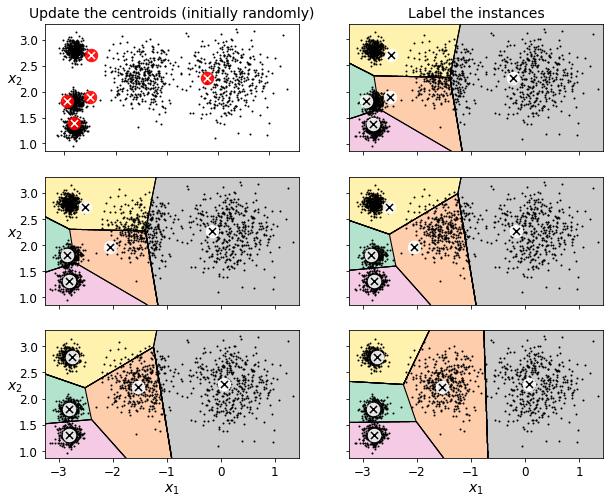

In [17]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom='off')
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

### K-Means Variability

In the original algo, the centroid are initialized randomly and the algo just runs a single iteration to gradually improve the centroids, as we saw above.

One __major__ problem to this approach is that if KMeans is run multiple times (or with different random seeds), it can converge to very different solutions, as shown below:

In [18]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


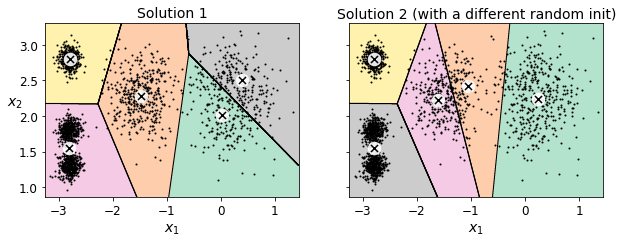

In [19]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

### Inertia

To select the best model, we need a way to evaluate the performance of the K-Means model. But since clustering is unsupervised, you don't have target labels to evaluate with. One thing that can be done is to measure the distance from each instance and its corresponding centroid. This is the idea behind the *inertia* metric:

In [20]:
kmeans.inertia_

211.5985372581684

Inertia is the sum of the squared distances between each training instance and its closest centroid, as shown below:

In [21]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

The `score()` method returns the negative inertia because the `score()` of a predictor must always follow the "*great is better*" rule:

In [22]:
kmeans.score(X)

-211.59853725816856

### Multiple Initializations

One approach to solve the aforementioned variability issue is to run the algo multiple times with different random initialization and to select the solution that minimizes inertia. Here's the inertia of the two "bad" models we trained earlier:

In [23]:
print(kmeans_rnd_init1.inertia_, kmeans_rnd_init2.inertia_)

223.29108572819035 237.46249169442848


Their inertia is higher than the first one, making them worse (probably).

The `n_init` hyperparam controls how many times that sklearn will run the algorithm and will select the solution that minimizes inertia. By default, Scikit-Learn will set `n_init=10`

In [24]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init='random', n_init=10, algorithm='full', random_state=11).fit(X)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

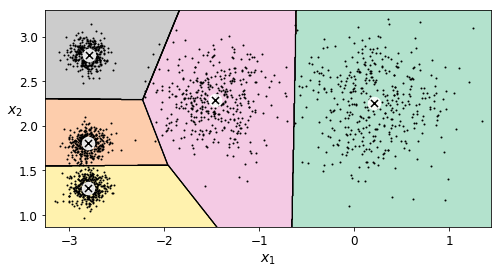

In [25]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of fully randomly initializing the centroids, you can use this [algorithm from a 2006 paper](https://scholar.google.com/scholar?hl=en&q=%22k-means%2B%2B%3A+The+advantages+of+careful+seeding%22) proposed by David Arthur and Sergei Vassilvitskii:

* Take one centroid $c_1$ chosen uniformly at random from the data.
* Take a new center $c_i$ choosing an instance $\textbf{x}_i$ with probability: $D(\textbf{x}_i)^2 / \sum_{j=1}^mD(\textbf{x}_j)^2$ where $D(\textbf{x}_i)$ is the distance between the instance $\textbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further aray from chosen centroids are more likely to be chosen.
* Repeat previous step until all $k$ centroids are chosen.

The rest of K-Means++ is just K-Means. This initialization makes the algo much less likely to converge to a suboptimal solution, so the `n_init` can be reduced significantly.

To use this algo, set `init='k-means++'` (which is the default, actually):

In [26]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### Accelerated K-Means

The algo can be significantly accelerated by avoiding unnecessary distance calculations. This is achieved by exploiting the triangle inequality (given three points A, B, and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of the lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use this variation, set `algorithm='elkan'`. This doesn't support sparse data, so sklearn will use `elkan` for dense data and `full` for sparse data (`full` being the regular algorithm):

In [27]:
%timeit -n 50 KMeans(algorithm='elkan').fit(X)

67.7 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [28]:
%timeit -n 50 KMeans(algorithm='full').fit(X)

89.9 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch

Scikit-Learn also supports mini-batch learning. See [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf) for details:

In [29]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=5,
        n_init=3, random_state=42, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [30]:
minibatch_kmeans.inertia_

211.9318653147678

If the data doesn't fit in memory, you can do the following (just like incremental PCA) and use the `memmap` class

```
filename = "my_mnist.data"
m, n = 50000, 28*28
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)
```

Mini-batch tends to be faster than K-Means but at the expense of higher inertia.


### Finding Optimal Number of Clusters

What if the number of clusters was set to a lower or greater value than 5?

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


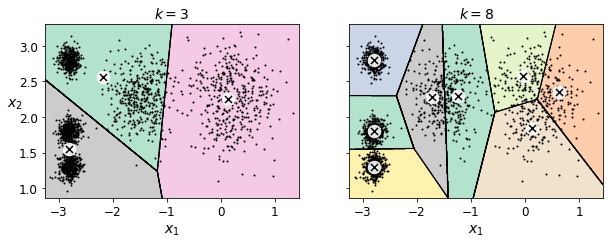

In [31]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, '$k=3$', '$k=8$')
plt.show()

These models don't look great, let's check inertias:

In [32]:
print(kmeans_k3.inertia_, kmeans_k8.inertia_)

653.2167190021553 119.11983416102879


We can't just take the value of $k$ that minimizes inertia since it will decrease as $k$ increases. We can however plot inertia as a function of $k$ and analyze the resulting curve:

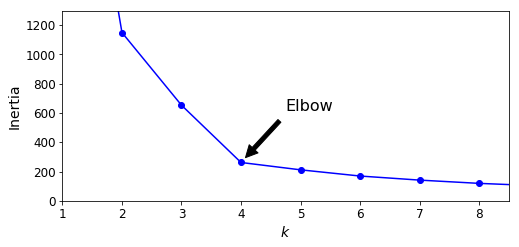

In [33]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

There's an elbow at $k = 4$ so more clusters won't be helpful and less clusters will not do anything. This makes $k = 4$ a decent choice.

Another approach is to look at the *silhouette score* which is the mean _silhouette coefficient_ over all of the instances. An instance's silhouette coefficient is equal to $(a - b) / \text{max}(a, b)$, where $a$ is the mean distance to the other instances in the same cluster (a.k.a. the *mean intra-cluster distance*) and $b$ is the *mean nearest-cluster distance*, that is, the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster. The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot silhouette score as a function of $k$:

In [34]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

In [35]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

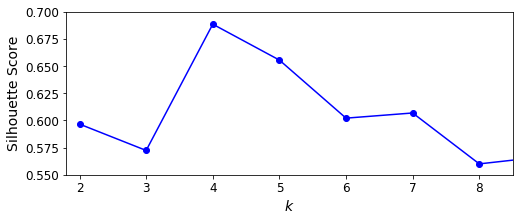

In [36]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, 'bo-')
plt.xlabel("$k$", fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_:

### Limits of K-Means

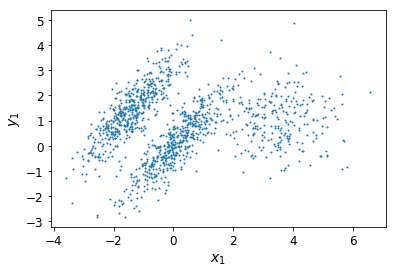

In [37]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 += [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_cluster(X)

In [38]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


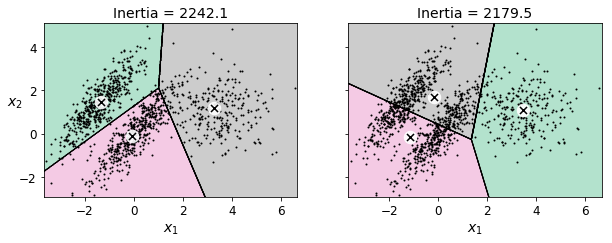

In [39]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)
plt.show()

### Using Clustering for Image Segmentation

In [40]:
from matplotlib.image import imread
image = imread(os.path.join('..', 'images', 'unsupervised_learning', 'ladybug.png'))
image.shape

(533, 800, 3)

In [41]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [42]:
segmented_imgs = list()
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

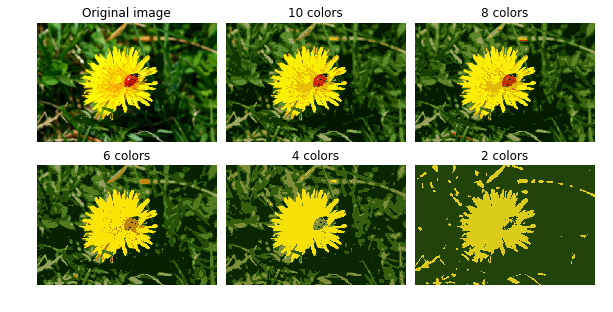

In [43]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

## Using Clustering for Preprocessing

Let's tackle the *digits dataset* which is similar to MNIST containing 1,797 greyscale 8x8 images representing digits 0-9:

In [44]:
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y=True)

# split our data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Now let's use Logistic Regression and evaluate it:

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
log_reg.score(X_test, y_test)

0.9666666666666667

Our benchmark is 97%. Let's see if using K-Means for preprocessing will improve anything. We'll make a Pipeline that clusters our training set and replace the images with distances to 50 clusters, then apply logistic regression:

In [47]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50, random_state=42)),
    ('log_reg', LogisticRegression(random_state=42))
])

pipeline.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [48]:
pipeline.score(X_test, y_test)

0.9822222222222222

In [49]:
# check how much error rate was reduced
1 - (1 - 0.982222) / (1 - 0.966667)

0.46665466654666576

We almost reduced the error by a factor of 2! This was with randomly choosing $k$; let's do better. We'll use `GridSearchCV` to find the best possible $k$ value.

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................
[CV] ............................. kmeans__n_clusters=5, total=   0.1s
[CV] kmeans__n_clusters=5 ............................................
[CV] .

[CV] ............................ kmeans__n_clusters=22, total=   0.2s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   0.2s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.2s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.2s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   0.2s
[CV] kmeans__n_clusters=24 ...........................................
[CV] ............................ kmeans__n_clusters=24, total=   0.2s
[CV] kmeans__n_clusters=24 ...........................................
[CV] ............................ kmeans__n_clusters=24, total=   0.2s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   0.3s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.4s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.4s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   0.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   0.4s
[CV] kmeans__n_clusters=44 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=61, total=   0.5s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   0.5s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   0.5s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   0.5s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   0.5s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   0.5s
[CV] kmeans__n_clusters=63 ...........................................
[CV] ............................ kmeans__n_clusters=63, total=   0.5s
[CV] kmeans__n_clusters=63 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=80, total=   0.6s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   0.6s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   0.6s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   0.7s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   0.7s
[CV] kmeans__n_clusters=82 ...........................................
[CV] ............................ kmeans__n_clusters=82, total=   0.6s
[CV] kmeans__n_clusters=82 ...........................................
[CV] ............................ kmeans__n_clusters=82, total=   0.6s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   0.8s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed:  2.1min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dua...lty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kmeans__n_clusters': range(2, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [51]:
grid_clf.best_params_

{'kmeans__n_clusters': 90}

In [52]:
grid_clf.score(X_test, y_test)

0.9844444444444445

The performance is slightly better when $k = 90$ so 90 it is.

### Clustering for Semi-Supervised Learning

Another use case for clustering is for semi-supervised learning (when we have a bunch of unlabeled instances and only a few labeled ones)

Let's see how Logistic Regression (a supervised learning model) does when only 50 of the instances are labeled.

In [53]:
n_labeled = 50

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8266666666666667

It's worse than earlier (obviously). Let's improve it by clustering the training set into 50 clusters, then for each we'll find the image closest to the centroid. We'll call those images the *representative images*

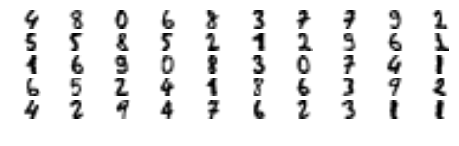

In [54]:
k = 50

kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

# Plot figures
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap='binary', interpolation='bilinear')
    plt.axis('off')
    
plt.show()

In [57]:
# Manually label the figures
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 5, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 6, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Now our dataset has 50 labeled instances, but each of those instances is representative of its cluster that it came from. Let's see if the performance got better:

In [59]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8933333333333333

That's a pretty decent increase in accuracy. Let's go one step further and propagate the labels to the other instances in the cluster:

In [60]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]
    
# retrain
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8911111111111111

Interestingly, we did slightly worse. We may have propagated too far to outliers, so let's change that:

In [61]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [62]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

# retrain
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
log_reg.score(X_test, y_test)

0.8977777777777778

From here, we could do some *active learning* like:

1) Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.

2) Train a new model with these additional labels

## DBSCAN

DBSCAN stands for *Density-Based Spatial Clustering of Applications with Noise*, and is an algorithm proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander, and Xiaowei Xu.

### About the Algorithm

DBSCAN is a clustering algorithm that classifies points as *core points*, *(density-)reachable points*, and *outliers* as follows:

* A point $p$ is a *core point* if at least $\text{minPts}$ points are within distance $\epsilon$ ($\epsilon$ is the maximum radius of the neighborhood from $p$) of it (including $p$ itself). These points are said to be *directly reachable* from $p$.
* A point $q$ is __directly reachable__ from $p$ if point $q$ is within distance $\epsilon$ from point $p$ and point $p$ is a core point.
* A point $q$ is *reachable* from $p$ if there is a path $p_1,\cdots,p_n$ with $p_1 = p$ and $p_n = q$ where each $p_{i+1}$ is directly reachable from $p_i$ (all the points of the path must be core points, with the possible exception of $q$).
* All points not reachable from any other point are called *outliers*

A *cluster* must therefore satisfy the next two properties:

* All points within the cluster are mutually density-connected
* If a point is density-reachable from any point of the cluster, it is part of the cluster as well.

The pseudocode for the algorithm can be found [here](https://en.wikipedia.org/wiki/DBSCAN), but the high-level description is as follows:

1) Find the points in the $\epsilon$ neighborhood of every point, and identify the core points with more than $\text{minPts}$ neighbors.

2) Find the connected components of *core points* on the neighborhood graph, ignoring all non-core points.

3) Assign each non-core point to a nearby cluster if the cluster is in an $\epsilon$ neighborhood, otherwise assign it to noise.

We'll use the `make_moons` to create a new dataset for using this.

In [64]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [65]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [66]:
len(dbscan.core_sample_indices_)

808

In [67]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [68]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [69]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [70]:
# try it with a larger epsilon
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=1, p=None)

In [71]:
# plot the scans
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


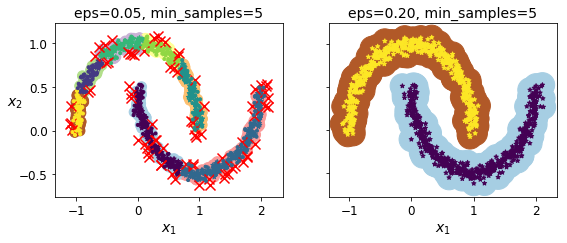

In [72]:
plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [73]:
dbscan = dbscan2

# We'll now throw in a KNearestNeighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [74]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [75]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

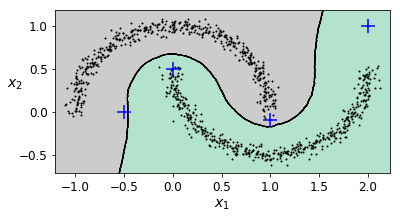

In [76]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
plt.show()

In [77]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## Other Clustering Algorithms

### Spectral Clustering

Spectral clustering takes advantages of the eigenvalues of the similarity matrix of the data to perform dimensionality reduction before clustering the data in fewer dimensions. The algorithm is explained pretty well [here](https://en.wikipedia.org/wiki/Spectral_clustering), so rather than explaining it, we'll just implement it using sklearn:

In [78]:
from sklearn.cluster import SpectralClustering

sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [79]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


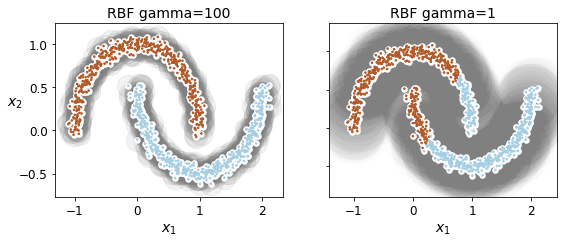

In [80]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Agglomerative Clustering

Agglomerative clustering is a form of [Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) where it recursively merges the pair of clusters that minimially increases a given linkage distance. The documentation is [here](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [81]:
from sklearn.cluster import AgglomerativeClustering

In [82]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage='complete').fit(X)

In [85]:
learned_parameters(agg)

['children_', 'labels_', 'n_components_', 'n_leaves_']

In [86]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

## Gaussian Mixtures

[Mixture models](https://en.wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) are probabilistic models for representing the presence of subpopulations inside of a larger population.